In [1]:
from transformers import SpeechT5Processor
from transformers.models.speecht5.modeling_speecht5 import (
    SpeechT5SpectrogramLoss,
    SpeechT5SpeechDecoderPostnet,
    SpeechT5PreTrainedModel,
    SpeechT5Config,
    SpeechT5DecoderWithSpeechPrenet,
    SpeechT5EncoderWithSpeechPrenet,
    SpeechT5Model,
    Seq2SeqSpectrogramOutput,
    SpeechT5HifiGan,
    shift_spectrograms_right,
    _generate_speech,
)
from datasets.load_datasets import AudioDataset
from torch.utils.data import Dataset as TorchDataset, DataLoader

import numpy as np

/home/kevincai/miniconda3/envs/speecht5/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

def visualize_spectrogram(signal, sample_rate):
  
# Plotting the first spectrogram
  plt.figure(figsize=(10, 4))
  plt.imshow(signal.T, aspect='auto', origin='lower', cmap='jet')
  plt.colorbar(label='Magnitude')
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.title('First Spectrogram in the Batch')
  plt.show()

def visualize_waveform(signal, sample_rate):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=sample_rate)
  plt.title('Waveform')
  plt.show()


In [3]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")
hifi_gan = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_vc")

You are using a model of type speecht5 to instantiate a model of type hifigan. This is not supported for all configurations of models and can yield errors.
Some weights of SpeechT5HifiGan were not initialized from the model checkpoint at microsoft/speecht5_vc and are newly initialized: ['resblocks.8.convs1.2.bias', 'upsampler.3.bias', 'resblocks.5.convs2.2.weight', 'resblocks.10.convs1.1.bias', 'resblocks.1.convs1.0.weight', 'resblocks.8.convs2.1.bias', 'resblocks.1.convs2.2.bias', 'resblocks.7.convs1.0.bias', 'scale', 'upsampler.1.bias', 'resblocks.7.convs1.1.weight', 'resblocks.5.convs2.0.weight', 'resblocks.3.convs2.0.bias', 'resblocks.10.convs1.0.weight', 'resblocks.10.convs2.2.bias', 'resblocks.3.convs2.2.bias', 'resblocks.6.convs1.0.bias', 'resblocks.0.convs2.1.bias', 'resblocks.5.convs1.2.bias', 'resblocks.7.convs2.2.weight', 'resblocks.3.convs1.1.bias', 'resblocks.1.convs2.1.bias', 'resblocks.9.convs1.0.weight', 'resblocks.5.convs2.0.bias', 'resblocks.4.convs2.0.weight', 'resbl

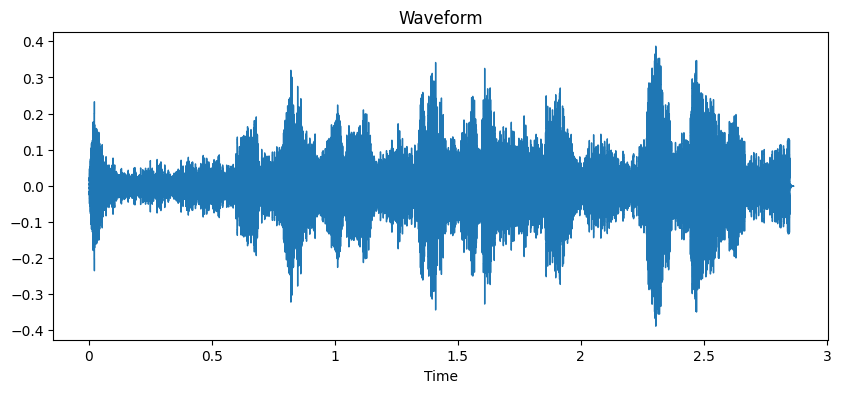

(626, 80)


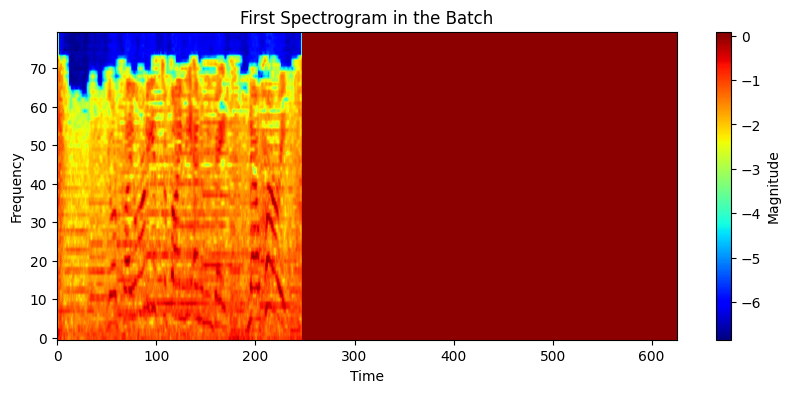

(625, 80)


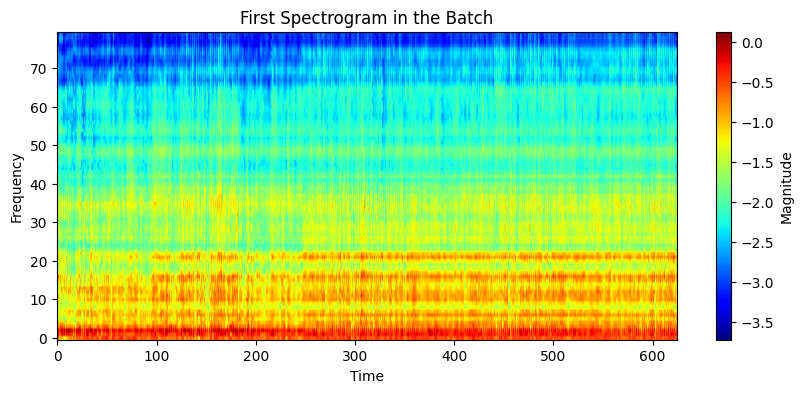

<class 'numpy.ndarray'>


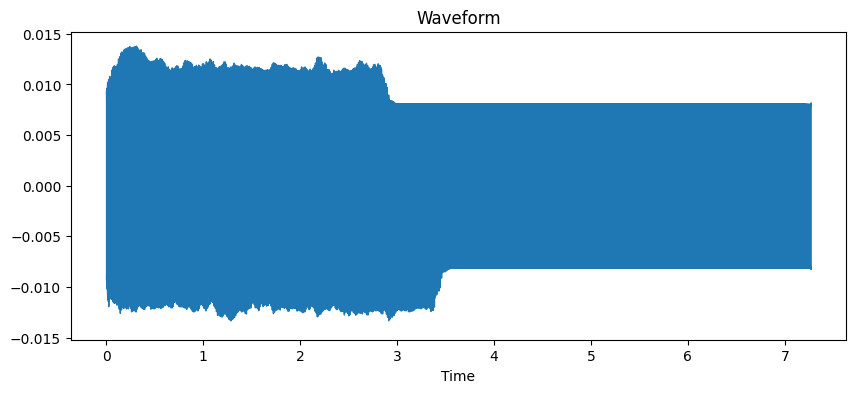

In [4]:
spectogram = np.load("spectrogram.npy")[0,:,:]
waveform = np.load("waveform.npy")
features = np.load("features.npy")[0,:,:]
visualize_waveform(waveform, 22050)
print(features.shape)
visualize_spectrogram(features, 22050)

print(spectogram.shape)
visualize_spectrogram(spectogram, 22050)
print(type(np.load("features.npy")))
feat_wave = np.load("spec_to_wave.npy")
visualize_waveform(feat_wave, 22050)


(63129,)
(16, 160256)
(63129,)


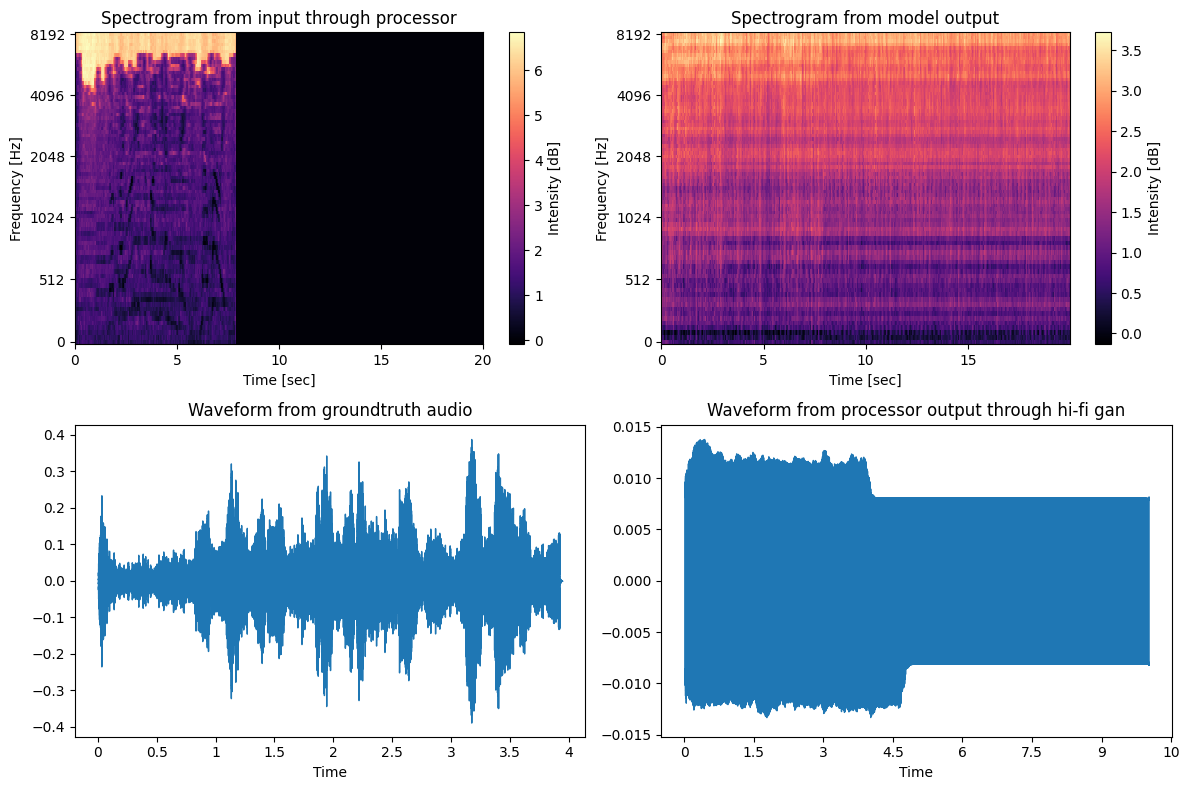

In [5]:

spectrogram1 = np.load("spectrogram.npy")[0,:,:]
waveform = np.load("waveform.npy")
print(waveform.shape)
features = np.load("features.npy")[0,:,:]
feat_wave = np.load("spec_to_wave.npy")

from scipy.signal import spectrogram

def visualize_spectrogram(signal, sample_rate, subplot):

    plt.subplot(subplot)

    # Display the spectrogram
    # S_dB = librosa.power_to_db(signal, ref=np.max)
    librosa.display.specshow(signal.T*-1, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8192)

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity [dB]')
    # plt.show()

    if subplot == 221:
        plt.title('Spectrogram from input through processor')
    else:
        plt.title('Spectrogram from model output')

def visualize_waveform(signal, sample_rate, subplot):
    plt.subplot(subplot)
    librosa.display.waveshow(signal, sr=sample_rate)
    if subplot == 223:
        plt.title('Waveform from groundtruth audio')
    else:
        plt.title('Waveform from processor output through hi-fi gan')

# Creating a 2x2 plot layout
plt.figure(figsize=(12, 8))

# Visualizing the data in a 2x2 layout
visualize_spectrogram(features, 16000, 221)
visualize_spectrogram(spectrogram1, 16000, 222)
print(feat_wave.shape)
visualize_waveform(feat_wave, 16000, 224)
print(waveform.shape)
visualize_waveform(waveform, 16000, 223)

plt.tight_layout()
plt.show()

-0.46822798
(1, 120576)
(120431,)


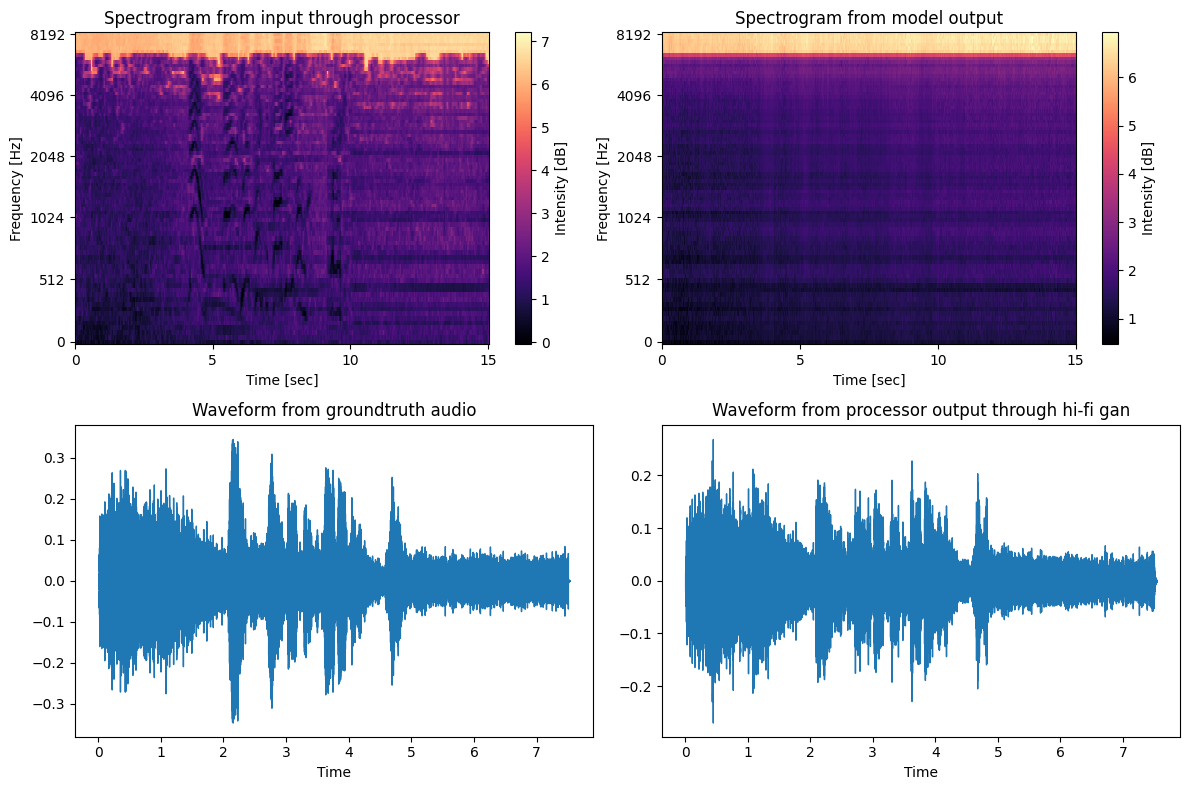

In [20]:
# Creating a 2x2 plot layout
plt.figure(figsize=(12, 8))
features = np.load("holder/features.npy")[0,:,:]
spectrogram1 = np.load("holder/spectrogram.npy")[0,:,:]
waveform = np.load("holder/waveform.npy")
feat_wave = np.load("holder/spec_to_wave.npy")
print(np.max(spectrogram1))
# Visualizing the data in a 2x2 layout
visualize_spectrogram(features, 16000, 221)
visualize_spectrogram(spectrogram1, 16000, 222)
print(feat_wave.shape)
visualize_waveform(feat_wave, 16000, 224)
print(waveform.shape)
visualize_waveform(waveform, 16000, 223)

plt.tight_layout()
plt.show()


In [7]:



# from IPython.display import Audio

# def play_numpy_waveform(waveform, sample_rate):
#     """
#     Play a numpy waveform in Jupyter Notebook.

#     :param waveform: Numpy array containing the waveform.
#     :param sample_rate: The sample rate of the waveform.
#     """
#     return Audio(waveform, rate=sample_rate)

# audio_output = play_numpy_waveform(feat_wave*10, 16000)
# audio_output

In [8]:
# features = processor(
#             audio=[waveform.squeeze().cpu().numpy() for waveform in jp_audio],
#             audio_target=[waveform.squeeze().cpu().numpy() for waveform in en_audio],
#             return_tensors="pt",
#             padding=True,
#             sampling_rate=16000,
#         )

In [9]:
import IPython.display as ipd

# Example to create a simple sine wave
fs = 22050  # Sample rate
duration = 5  # Duration in seconds
f = 440.0  # Sine frequency, Hz, A4-note
t = np.linspace(0, duration, int(fs * duration))  # Time array
sine_wave = 0.5 * np.sin(2 * np.pi * f * t)  # Generate sine wave

# Display the audio player
ipd.Audio(feat_wave, rate=fs)

163.22981


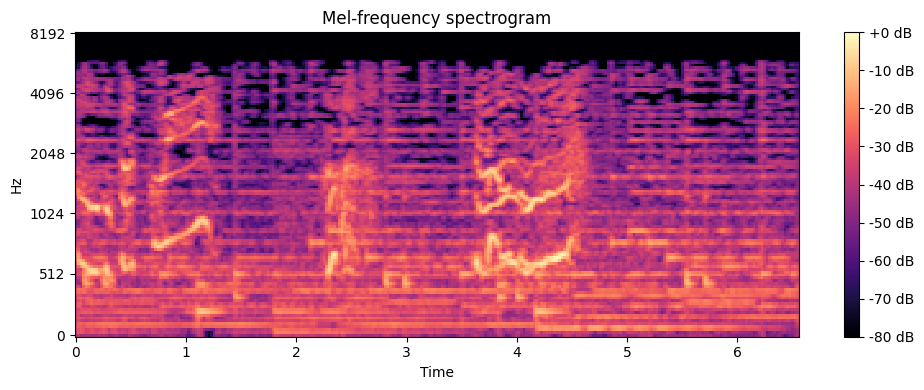

In [21]:
import librosa
import librosa.display

def generate_and_display_spectrogram(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)

    # Generate the spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8192)
    print(np.max(S))
    S_dB = librosa.power_to_db(S, ref=np.max)*-1

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8192)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

# Replace with t
generate_and_display_spectrogram("802166.mp3")    


In [11]:
import numpy as np
from pydub import AudioSegment

def save_numpy_as_mp3(numpy_array, sample_rate, file_name):
    """
    Save a numpy array as an MP3 file.

    :param numpy_array: Numpy array containing audio data.
    :param sample_rate: Sample rate of the audio data.
    :param file_name: File name to save the audio to (including the '.mp3' extension).
    """
    # Ensure that the numpy array is in int16 format
    numpy_array = np.int16(numpy_array)

    # Create an audio segment
    audio_segment = AudioSegment(
        numpy_array.tobytes(), 
        frame_rate=sample_rate,
        sample_width=numpy_array.dtype.itemsize, 
        channels=1
    )

    # Export to MP3
    audio_segment.export(file_name, format='mp3')
    
save_numpy_as_mp3(feat_wave, 16000, "test.mp3")

/home/kevincai/miniconda3/envs/speecht5/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'